Solves the adjustment problem in 2D as described by Killworth et al. (1991):

 * CROSS-EQUATORIAL GEOSTROPHIC ADJUSTMENT
 * http://journals.ametsoc.org/doi/pdf/10.1175/1520-0485%281991%29021%3C1581%3ACEGA%3E2.0.CO%3B2

Author:
        Dion Häfner (mail@dionhaefner.de)

In [1]:
%matplotlib inline

In [2]:
inifile = "parameters.ini"

# IMPORT PACKAGES

In [3]:
import matplotlib as mpl
#mpl.use('Agg')
from matplotlib import pyplot as plt
from fipy import *
from fipy.tools import numerix
from fipy.meshes.uniformGrid2D import UniformGrid2D
import sys
import os
try:
    import seaborn as sns
    sns.set("talk")
    have_seaborn = True
except ImportError:
    have_seaborn = False
import numpy as np
try:
    import ConfigParser as configparser
except ImportError:
    import configparser
import sys

# INITIALIZATION

## DEFINE CUSTOM "TYPES"

In [4]:
def floatlist(x):
    xlist = x.split()
    return list(map(float,xlist))

def intlist(x):
    xlist = x.split()
    return list(map(int,xlist))

## SET VALID PARAMETER KEYS

In [5]:
PARAMETER_KEYS = (
    ("general", (("name",str),)),
    ("domain", (("L",floatlist), ("N",intlist))),
    ("initial", (("Variable",str),("Val1",float),("Val2",float),("Y",floatlist))),
    ("parameters", (("Ah",float),("g",float),("beta",float),("H",float))),
    ("solver", (("t1",float), ("dtIncreaseFactor",float),
                ("dtDecreaseFactor",float),("absTol",float),
                ("timeStepDuration",float),("maxIterations",int))),
    ("output", (("outputEvery",float),))
)

## PARSE PARAMETER FILE

In [6]:
par = {}
config = configparser.RawConfigParser()
config.read(inifile)

for section, keys in PARAMETER_KEYS:
    for key, key_type in keys:
        try:
            par[key] = key_type(config.get(section, key))
        except ValueError:
            raise ValueError("Key {0} in section {1} must be of type {2}"\
                    .format(key,section,key_type))

## CONVERSION FACTORS

In [7]:
MS_TO_V = 1./np.sqrt(par["g"]*par["H"])
DAY_TO_T = np.sqrt(2*par["beta"]/MS_TO_V)*(3600*24)
KM_TO_X = np.sqrt(2*par["beta"]*MS_TO_V)*1000

## CREATE OUTPUT FOLDER

In [8]:
OUTPUT_PATH = "output/{0}".format(par["name"])
if not os.path.exists(OUTPUT_PATH):
    os.makedirs(OUTPUT_PATH)

## MESH SETUP

In [9]:
dLx = par["L"][0]/par["N"][0]* KM_TO_X
dLy = par["L"][1]/par["N"][1]* KM_TO_X
mesh = UniformGrid2D(nx=par["N"][0], ny=par["N"][1], dx=dLx, dy=dLy,
            origin=((-par["L"][0]/2 * KM_TO_X,),(-par["L"][1]/2 * KM_TO_X,)))

## VARIABLE SETUP

In [10]:
height = CellVariable(mesh=mesh, name='Column height', hasOld=True)
xVelocity = CellVariable(mesh=mesh, name='U', value=0., hasOld=True)
yVelocity = CellVariable(mesh=mesh, name='V', value=0., hasOld=True)
fVelocity = FaceVariable(mesh=mesh, name="Face velocity", rank=1, value=0.)

## INITIAL CONDITIONS

In [11]:
x, y = mesh.cellCenters
segment = np.logical_and(par["Y"][0]*KM_TO_X <= y, y <= par["Y"][1]*KM_TO_X)
if par["Variable"] == "height":
    height.setValue(par["Val2"])
    height.setValue(par["Val1"], where=segment)
elif par["Variable"] == "U":
    xVelocity.setValue(par["Val2"])
    xVelocity.setValue(par["Val1"], where=segment)
elif par["Variable"] == "V":
    yVelocity.setValue(par["Val2"])
    yVelocity.setValue(par["Val1"], where=segment)
else:
    raise ValueError("Initial condition parameter 'Variable' must either be "
                    "'height', 'U', or 'V'")

# EQUATION SETUP

In [12]:
coriolisTermX = ImplicitSourceTerm(var=yVelocity,coeff=.5*mesh.y)
coriolisTermY = ImplicitSourceTerm(var=xVelocity,coeff=.5*mesh.y)
if par["Ah"] != 0: # WITH FRICTION
    xVelocityEq = TransientTerm(var=xVelocity) + \
                    ConvectionTerm(coeff=fVelocity,var=xVelocity) - \
                    coriolisTermX - \
                    DiffusionTerm(coeff=par["Ah"],var=xVelocity) + \
                    height.grad.dot([1.,0.]) \
                    == 0
    yVelocityEq = TransientTerm(var=yVelocity) + \
                    ConvectionTerm(coeff=fVelocity,var=yVelocity) - \
                    coriolisTermY - \
                    DiffusionTerm(coeff=par["Ah"],var=yVelocity) + \
                    height.grad.dot([0.,1.]) \
                    == 0
elif par["Ah"] == 0: # WITHOUT FRICTION
    xVelocityEq = TransientTerm(var=xVelocity) + \
                    ConvectionTerm(coeff=fVelocity,var=xVelocity) - \
                    coriolisTermX + \
                    height.grad.dot([1.,0.]) \
                    == 0
    yVelocityEq = TransientTerm(var=yVelocity) + \
                    ConvectionTerm(coeff=fVelocity,var=yVelocity) - \
                    coriolisTermY + \
                    height.grad.dot([0.,1.]) \
                    == 0
heightEq = TransientTerm(var=height) + \
            ConvectionTerm(coeff=fVelocity,var=height) \
            == 0
eqSystem = xVelocityEq & yVelocityEq & heightEq # couple equations

# BOUNDARY CONDITIONS

In [13]:
xVelocity.constrain(0., mesh.exteriorFaces)
yVelocity.constrain(0., mesh.exteriorFaces)
height.faceGrad.constrain(0., mesh.exteriorFaces)

# SET UP VIEWERS

/Users/guyer/Documents/research/FiPy/fipy/fipy/viewers/matplotlibViewer/matplotlibStreamViewer.py:189: RuntimeWarning: invalid value encountered in greater
  mag = numerix.where(mag > datamax, numerix.nan, mag)
/Users/guyer/Documents/research/FiPy/fipy/fipy/viewers/matplotlibViewer/matplotlibStreamViewer.py:190: RuntimeWarning: invalid value encountered in less
  mag = numerix.where(mag < datamin, numerix.nan, mag)
/Users/guyer/anaconda/envs/fipy_petsc/lib/python2.7/site-packages/numpy/ma/core.py:806: RuntimeWarning: invalid value encountered in greater_equal
  return umath.absolute(a) * self.tolerance >= umath.absolute(b)
/Users/guyer/anaconda/envs/fipy_petsc/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


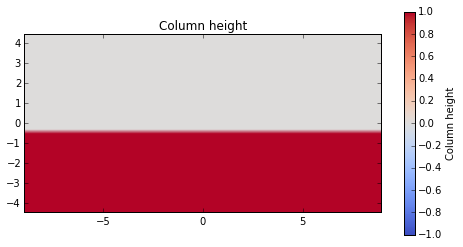

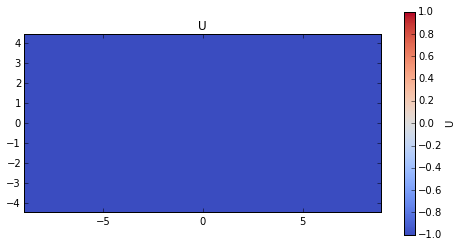

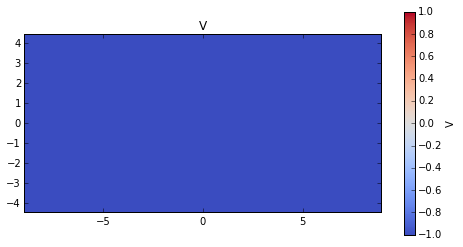

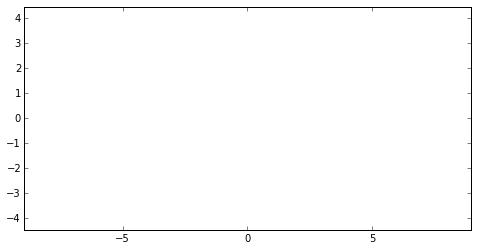

In [14]:
if have_seaborn:
    cmap = sns.diverging_palette(220, 10, as_cmap=True)
else:
    cmap = plt.get_cmap("coolwarm")
mplViewers = []
for var in (height,xVelocity,yVelocity):
    mplViewers.append(MatplotlibViewer(vars=(var),
        xmin=-par["L"][0]/2 * KM_TO_X, xmax=par["L"][0]/2 * KM_TO_X,
        ymin=-par["L"][1]/2 * KM_TO_X, ymax=par["L"][1]/2 * KM_TO_X,
        colorbar=True, cmap=cmap))
viewer = MultiViewer(mplViewers)
# fViewer = MatplotlibVectorViewer(vars=fVelocity,
#        xmin=-par["L"][0]/2 * KM_TO_X, xmax=par["L"][0]/2 * KM_TO_X,
#        ymin=-par["L"][1]/2 * KM_TO_X, ymax=par["L"][1]/2 * KM_TO_X,
#        sparsity=100, scale=.5)
fViewer = MatplotlibStreamViewer(vars=fVelocity,
        xmin=-par["L"][0]/2 * KM_TO_X, xmax=par["L"][0]/2 * KM_TO_X,
        ymin=-par["L"][1]/2 * KM_TO_X, ymax=par["L"][1]/2 * KM_TO_X)
vtkViewer = VTKCellViewer(vars=(height, xVelocity, yVelocity))

## CONCENIENCE FUNCTION TO PLOT ALL VIEWERS AT ONCE

In [15]:
def output(t):
    for v in viewer.viewers:
        v.plot("{0}/{1}-{2:.2f}days.png"\
                .format(OUTPUT_PATH,v.title,t/DAY_TO_T))
#    fViewer.quiver()
    fViewer.plot("{0}/velocity-{1:.2f}days.png".format(OUTPUT_PATH,t/DAY_TO_T))
    vtkViewer.plot("{0}/day{1:.2f}.vtu".format(OUTPUT_PATH,t/DAY_TO_T))

## PLOT INITIAL STATE

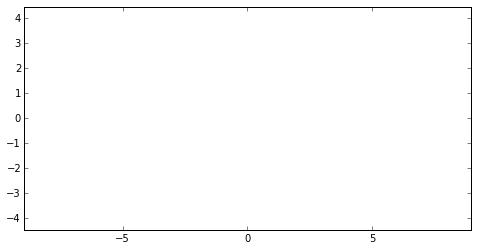

In [16]:
output(0)

# MAIN TIME LOOP

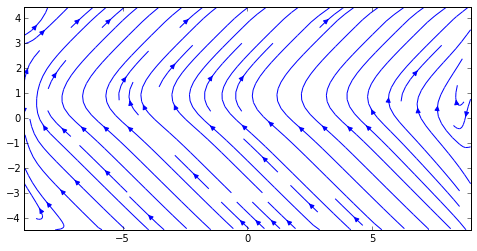


INCREASING DT
 Current time: 4.3e+00	Time step: 1.0e-03
Residual: 7.52e-11
INCREASING DT
 Current time: 4.3e+00	Time step: 1.2e-03
Residual: 3.29e-10
REDUCING DT
Residual: 2.91e-11
INCREASING DT
 Current time: 4.3e+00	Time step: 7.3e-04
Residual: 6.30e-12
INCREASING DT
 Current time: 4.3e+00	Time step: 8.8e-04
Residual: 2.39e-11
INCREASING DT
 Current time: 4.3e+00	Time step: 1.1e-03
Residual: 1.06e-10
REDUCING DT
Residual: 8.77e-12
INCREASING DT
 Current time: 4.3e+00	Time step: 6.3e-04

INCREASING DT
 Current time: 4.3e+00	Time step: 7.6e-04
Residual: 7.59e-12
INCREASING DT
 Current time: 4.3e+00	Time step: 9.1e-04
Residual: 3.36e-11
INCREASING DT
 Current time: 4.3e+00	Time step: 1.1e-03
Residual: 1.48e-10
REDUCING DT
Residual: 1.22e-11
INCREASING DT
 Current time: 4.3e+00	Time step: 6.5e-04

INCREASING DT
 Current time: 4.3e+00	Time step: 7.9e-04
Residual: 1.08e-11
INCREASING DT
 Current time: 4.3e+00	Time step: 9.4e-04
Residual: 4.66e-11
INCREASING DT
 Current time: 4.3e+00	Time 

KeyboardInterrupt: 

In [17]:
t = 0.
dt = par["timeStepDuration"]
while t < (par["t1"] * DAY_TO_T):
    xVelocity.updateOld()
    yVelocity.updateOld()
    height.updateOld()
    residual = 1
    j = 0
    # ITERATIVE SOLUTION LOOP
    while residual > par["absTol"]:
        fVelocity[0] = xVelocity.arithmeticFaceValue
        fVelocity[1] = yVelocity.arithmeticFaceValue
        fVelocity[..., mesh.exteriorFaces.value] = 0.
        residual = eqSystem.sweep(dt = dt)
        j += 1
        if j > par["maxIterations"]:
            dt /= par["dtDecreaseFactor"]
            print("\nREDUCING DT")
            output_now = False
            j = 0
        sys.stdout.write("Residual: {0:.2e}\r".format(residual))
    t += dt

    # PRINT OUTPUT
    if output_now:
        output(t)
        output_now = False
        dt = dtTemp * par["dtIncreaseFactor"]

    # CHECK IF OUTPUT IS DUE AFTER NEXT TIME STEP
    nextOutput = t % (par["outputEvery"] * DAY_TO_T)
    outputTimestep = (par["outputEvery"] * DAY_TO_T) - nextOutput
    if outputTimestep < par["dtIncreaseFactor"]*dt:
        output_now = True
        dtTemp = dt
        dt = outputTimestep + 1E-4
        print("\nLIMITING DT\n Current time: {0:.1e}\tTime step: {1:.1e}"\
                .format(t,dt))
    else:
        output_now = False
        dt *= par["dtIncreaseFactor"]
        print("\nINCREASING DT\n Current time: {0:.1e}\tTime step: {1:.1e}"\
                .format(t,dt))